In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from ta.momentum import RSIIndicator
import joblib

In [58]:
asset1_data = pd.read_csv("C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/currency_data/EBAY.csv")
asset2_data = pd.read_csv("C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/currency_data/DAL.csv")

In [59]:
# The columns 'vw', 'n', and 't' are unnecessary, so they are being dropped.
asset2_data.drop(columns=['vw','n','t'],inplace=True)
asset1_data.drop(columns=['vw','n','t'],inplace=True)

# Renaming columns to have more understandable names for the features.
columns_mapping = {
    'c': 'close',
    'h': 'high',
    'l': 'low',
    'o': 'open',
    'v': 'volume'
}

asset2_data = asset2_data.rename(columns=columns_mapping)
asset1_data = asset1_data.rename(columns=columns_mapping)

In [60]:
# Adding financial features to the data.
def add_features(data) :
    data['price_range'] = data['high'] - data['low']
    data['body_size'] = data['close'] - data['open']
    data['upper_shadow'] = data['high'] - data[['open', 'close']].max(axis=1)
    data['lower_shadow'] = data[['open', 'close']].min(axis=1) - data['low']
    data['daily_return'] = (data['close'] - data['open']) / data['open']
    data['log_return'] = np.log(data['close'] / data['open'])
    data['volume_change'] = data['volume'].diff()
    data['average_price'] = (data['high'] + data['low'] + data['close']) / 3
    data['price_change'] = data['close'].diff()
    data['rolling_mean'] = data['close'].rolling(window=5).mean()
    data['rolling_std'] = data['close'].rolling(window=5).std()

    rsi_period = 14
    rsi = RSIIndicator(data['close'], window=rsi_period).rsi()
    data['rsi'] = rsi

    short_ema = data['close'].ewm(span=12, adjust=False).mean()
    long_ema = data['close'].ewm(span=26, adjust=False).mean()
    data['macd'] = short_ema - long_ema

    data['14_high'] = data['high'].rolling(window=14).max()
    data['14_low'] = data['low'].rolling(window=14).min()
    data['stochastic'] = (data['close'] - data['14_low']) / (data['14_high'] - data['14_low']) * 100

    data.drop(['14_high', '14_low'], axis=1, inplace=True)

In [61]:
add_features(asset2_data)
add_features(asset1_data)

In [62]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(asset2_data)
asset2_data = pd.DataFrame(data_scaled, columns=asset2_data.columns)
asset2_data.dropna(inplace=True)
asset2_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic
13,2.821847,2.765682,2.627983,2.682959,-0.546964,1.173354,1.322306,-0.645504,1.670768,0.807565,0.800045,0.080798,2.741834,0.582755,2.942705,0.227002,0.614370,0.535720,0.344004
14,2.630200,2.743909,2.582132,2.796177,-0.316790,1.415023,-1.422418,-0.476632,1.593366,-0.830051,-0.814041,0.425856,2.655215,-1.318415,2.860975,0.404016,-0.393060,0.425800,-0.471073
15,2.370294,2.344073,2.291304,2.327506,-0.111613,0.356908,0.446834,0.106743,1.335359,0.292752,0.299371,0.379610,2.338122,-1.791434,2.722540,0.784781,-1.260820,0.223916,-1.098257
16,2.455617,2.448321,2.439338,2.467054,-0.633549,-0.087239,-0.038225,0.321671,0.974149,-0.011865,0.000247,-0.965564,2.450837,0.600948,2.646400,0.771959,-0.857909,0.100158,-0.790394
17,2.346666,2.425887,2.415758,2.478902,-0.689527,-0.074176,-1.126651,-0.476632,-0.702894,-0.683791,-0.667299,-0.103530,2.399085,-0.745335,2.566800,0.889635,-1.162479,-0.044195,-1.183511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,1.137713,1.198668,1.165985,1.265095,-0.295614,0.239340,-1.114820,-0.722264,0.148528,-0.812793,-0.796700,0.677985,1.168871,-1.045520,1.299319,-0.248778,-1.199395,-0.403114,-1.351128
1129,1.069455,1.119836,1.127339,1.184789,-0.486019,-0.155690,-1.008344,-0.683577,-0.431987,-0.744410,-0.728054,-0.352223,1.106926,-0.463343,1.233296,-0.157566,-1.375671,-0.488424,-1.536431
1130,1.041889,1.038998,1.098518,1.078153,-0.671910,-0.668549,-0.298501,-0.077481,-0.406187,-0.220436,-0.205816,-0.343873,1.061200,-0.181352,1.177389,-0.138706,-1.445493,-0.561087,-1.535830
1131,1.131149,1.062090,1.150907,1.097901,-0.865778,-0.962339,0.328527,-0.737616,-0.302726,0.253654,0.261099,-0.358631,1.116237,0.628238,1.156358,-0.247214,-0.991390,-0.572970,-0.957931


In [63]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(asset1_data)
asset1_data = pd.DataFrame(data_scaled, columns=asset1_data.columns)
asset1_data.dropna(inplace=True)
asset1_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic
13,-1.440763,-1.451086,-1.395535,-1.414261,0.331704,-1.348516,-0.259778,-0.577912,-0.877721,-0.376008,-0.368882,0.073040,-1.430126,-0.273532,-1.431626,-1.396278,-0.316284,-0.148116,0.543257
14,-1.464423,-1.468837,-1.438053,-1.417093,0.527626,-0.977346,-0.494438,-1.076210,-0.197849,-0.714553,-0.711405,0.206406,-1.458028,-0.245710,-1.442269,-1.252577,-0.773554,-0.162671,0.045818
15,-1.453066,-1.473508,-1.471494,-1.511500,0.783470,-0.540675,0.700193,-0.266476,-0.964884,1.038067,1.039262,0.269424,-1.466855,0.097437,-1.448731,-1.255523,-0.504307,-0.164870,0.298578
16,-1.383981,-1.407177,-1.401268,-1.434086,1.671031,-0.577064,0.604196,-0.328763,-0.668530,0.873849,0.877565,0.933765,-1.398284,0.663165,-1.439418,-1.011940,0.714295,-0.114643,1.153273
17,-1.538240,-1.493127,-1.510190,-1.486482,2.911958,-0.256839,-0.542436,0.403112,-0.285013,-0.799059,-0.797237,1.305379,-1.514618,-1.525553,-1.464316,-0.576279,-1.253674,-0.189199,-1.375384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,0.273125,0.227733,0.240690,0.203877,-0.198659,-0.118559,0.774858,-0.359907,-0.093254,0.736341,0.741802,0.641318,0.247257,0.607519,0.268643,-0.942190,0.170454,0.231007,0.077442
1129,0.174702,0.223996,0.203427,0.287900,-0.740356,0.390890,-1.283748,-0.889348,0.290264,-1.249042,-1.256542,-0.569305,0.200912,-0.978374,0.243366,-0.672954,-0.371274,0.144719,-0.870003
1130,0.228645,0.175883,0.179063,0.167059,-0.806545,0.012442,0.689527,-0.624628,0.795809,0.658454,0.664756,-0.069240,0.194607,0.514777,0.230061,-0.835697,-0.077184,0.114330,-0.350731
1131,0.168077,0.194848,0.198649,0.248060,-1.085079,0.009531,-0.908292,-0.546769,0.220533,-0.895924,-0.895787,-0.292552,0.187293,-0.607405,0.209535,-0.814013,-0.392634,0.043341,-0.933774


In [64]:
# Train Model
hmm_model_asset2 = GaussianHMM(n_components=4, covariance_type='full', n_iter=1000)
hmm_model_asset2.fit(asset2_data)

Model is not converging.  Current: 31093.864596770763 is not greater than 46084.476719353006. Delta is -14990.612122582243


GaussianHMM(covariance_type='full', n_components=4, n_iter=1000)

In [65]:
hmm_model_asset1 = GaussianHMM(n_components=4, covariance_type='full', n_iter=1000)
hmm_model_asset1.fit(asset1_data)

Model is not converging.  Current: 26146.174900178743 is not greater than 41576.64102436728. Delta is -15430.466124188537


GaussianHMM(covariance_type='full', n_components=4, n_iter=1000)

In [66]:
# Check Results
hidden_states_asset2 = hmm_model_asset2.predict(asset2_data)
hidden_states_asset1 = hmm_model_asset1.predict(asset1_data)

In [67]:
def labella(data,hidden_states):
    i = 0
    labels_0 = []
    labels_1 = []
    labels_2 = []
    labels_3 = []
    prices = data["close"].values.astype(float)

    for s in hidden_states:
        if s == 0:
            labels_0.append(prices[i])
            labels_1.append(float('nan'))
            labels_2.append(float('nan'))
            labels_3.append(float('nan'))
        if s == 1:
            labels_0.append(float('nan'))
            labels_1.append(prices[i])
            labels_2.append(float('nan'))
            labels_3.append(float('nan'))
        if s == 2:
            labels_0.append(float('nan'))
            labels_1.append(float('nan'))
            labels_2.append(prices[i])
            labels_3.append(float('nan'))
        if s == 3:
            labels_0.append(float('nan'))
            labels_1.append(float('nan'))
            labels_2.append(float('nan'))
            labels_3.append(prices[i])

        i += 1
    
    return labels_0,labels_1,labels_2,labels_3

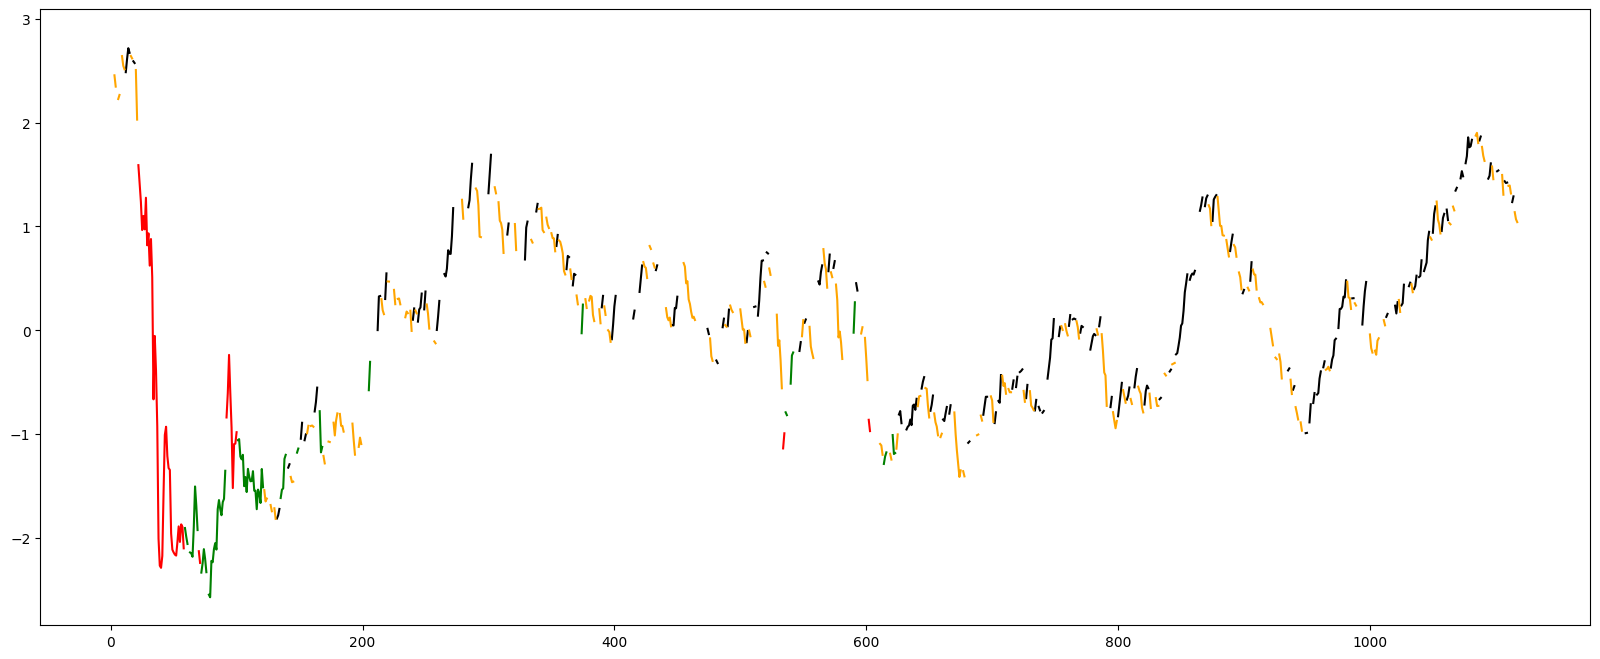

In [68]:
# Plot Chart
labels_0,labels_1,labels_2,labels_3 = labella(asset2_data,hidden_states_asset2)
fig = plt.figure(figsize= (20, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="black")
plt.plot(labels_2, color="red")
plt.plot(labels_3, color="orange")
plt.show()

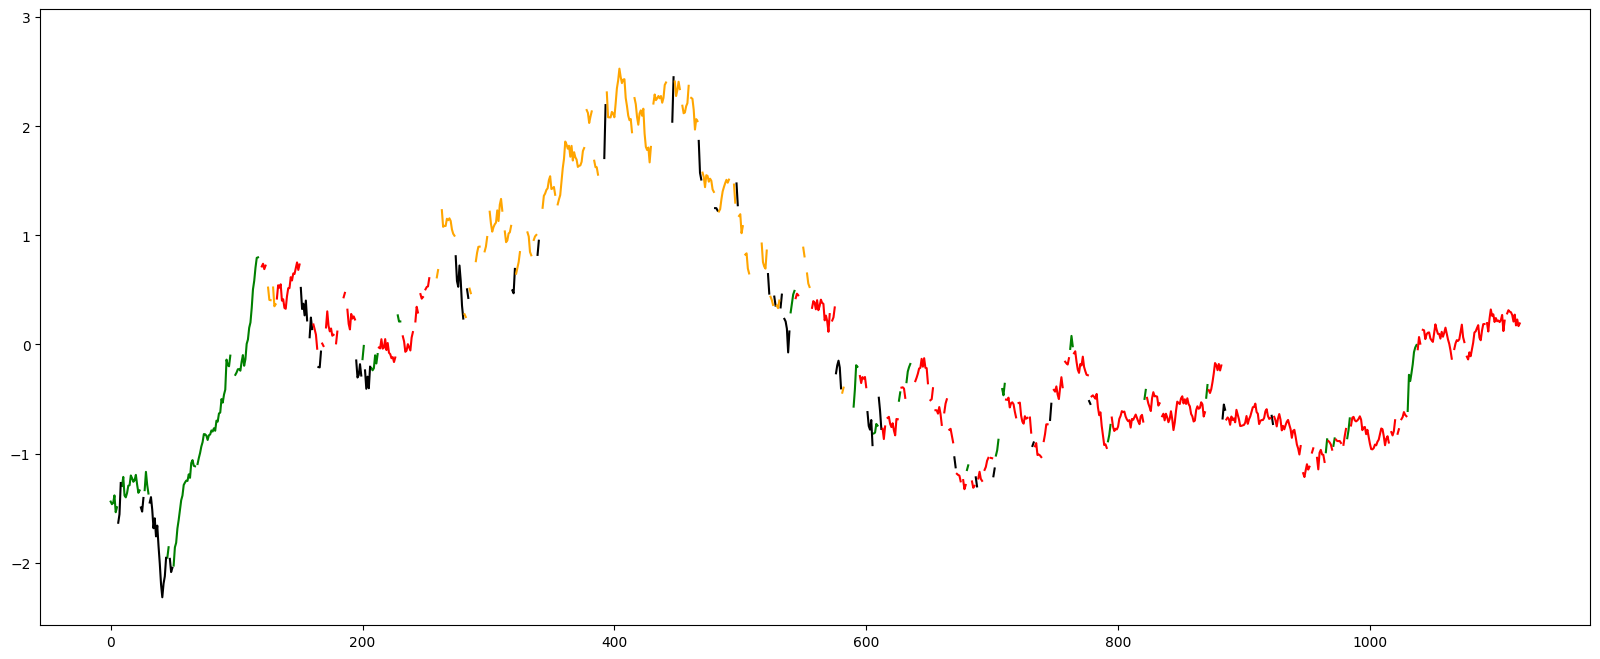

In [69]:
labels_0,labels_1,labels_2,labels_3 = labella(asset1_data,hidden_states_asset1)
fig = plt.figure(figsize= (20, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="black")
plt.plot(labels_2, color="red")
plt.plot(labels_3, color="orange")
plt.show()

In [70]:
# Modeli kaydetme
joblib.dump(hmm_model_asset1, 'hmm_model_ebay.pkl')
joblib.dump(hmm_model_asset2, 'hmm_model_dal.pkl')

['hmm_model_dal.pkl']